# A Brief Introduction to Data Analysis in Python
## Notebook by Daniel Lowd, 10/5/2017
## Created for CIS 399, Probability and Statistics for Computer Science

In this Python notebook, we will explore basic data manipulation and plotting using the pandas library. In particular, we will focus on concepts covered in Chapter 1 of [OpenIntro Statistics](http://openintro.org/stat/).

Air quality index (AQI) is a number that describes how dangerous the air is to breathe. Higher numbers correspond to more pollutants in the air, making it less healthy. You can find information on the air quality in Lane county from the [Lane Regional Air Protection Agency (LRAPA)](http://www.lrapa.org). Their website tracks the current air quality in three regions: Eugene/Springfield, Cottage Grove, and Oakridge. They also support downloading information on the past air quality.

I've downloaded 5 years of AQI information for us to explore. You can find the CSV file here: [aqi-lanecounty-2012-2017.csv](http://ix.cs.uoregon.edu/~lowd/aqi-lanecounty-2012-2017.csv). In the following, we'll explore and analyze this data in a variety of ways.

## Loading data
First, we'll read in the data and look at the columns, their types, and some basic summary statistics.

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# This tells matplotlib to draw plots inline in IPython. Otherwise, it creates new windows for the plots.
%matplotlib inline

In [2]:
# First, read the dataset. Pandas can read from local files or URLs, and supports CSV and Excel.
df = pd.read_csv('http://ix.cs.uoregon.edu/~lowd/aqi-lanecounty-2012-2017.csv')

# A good place to start is to look at the data. head() shows the first few rows.
df.head()

,Observation Date,Reporting Area,AQI,AQI Category,Pollutant
0,2012-09-01,Cottage Grove,33.0,Good,Ozone
1,2012-09-01,Eugene/Springfield,31.0,Good,Ozone
2,2012-09-01,Oakridge,12.0,Good,Particulate Matter
3,2012-09-02,Cottage Grove,34.0,Good,Ozone
4,2012-09-02,Eugene/Springfield,31.0,Good,Ozone


In [3]:
# dtypes shows the type of each column in the data.
df.dtypes

Observation Date     object
Reporting Area       object
AQI                 float64
AQI Category         object
Pollutant            object
dtype: object

In [4]:
# You can get basic properties on all numeric columns with describe(). In this case, there's just one -- AQI.
# You can get individual values as well with mean(), std(), etc.
df.describe()

,AQI
count,5051.000000
mean,33.915066
std,21.503684
min,1.000000
25%,19.000000
50%,30.000000
75%,42.000000
max,186.000000


In [5]:
# Select data from a data frame using attribute tests
df[('2016-09-01' < df['Observation Date']) & (df['Observation Date'] < '2017-08-31')]['AQI'].mean()

32.322610294117645

In [6]:
#...or ranges
df[0:1000]['AQI'].mean()

31.199745547073793

## Changing category names and order
This data frame is just treating the categories as arbitrary strings. We can change the names and add categories manually if we want, though it's a bit of a hassle.

In [7]:
# Change type to category
df['AQI Category'] = df['AQI Category'].astype('category')

# Here's the initial categories, set automatically
df['AQI Category'].cat.categories

Index(['Good', 'Moderate', 'Unhealthy', 'Unhealthy for Sensitive Groups'], dtype='object')

In [8]:
# Here's how we rename them
df['AQI Category'].cat.categories = ['Good', 'Moderate', 'Unhealthy', 'Somewhat Unhealthy']

# Here's how we add new categories
df['AQI Category'] = df['AQI Category'].cat.add_categories(['Very Unhealthy'])

# Here's how to reorder
df['AQI Category'] = df['AQI Category'].cat.reorder_categories(['Good', 'Moderate', 'Somewhat Unhealthy', 'Unhealthy', 'Very Unhealthy'], ordered=True)

## Grouping
Let's see if the air quality varies from region to region. We can use groupby to turn a single dataframe into a collection of dataframes, corresponding to different values of the grouped attribute.

In [9]:
by_area = df.groupby('Reporting Area')
by_area.describe()

AQI                                                    
                     count       mean        std  min   25%   50%   75%    max
Reporting Area                                                                
Cottage Grove       1407.0  34.149964  17.320043  1.0  24.0  32.0  41.0  177.0
Eugene/Springfield  1826.0  35.162103  21.336264  3.0  21.0  31.0  43.0  186.0
Oakridge            1818.0  32.480748  24.333966  5.0  15.0  24.0  43.0  179.0

In [10]:
# We can analyze categorical values with value_counts()
by_area['AQI Category'].value_counts()

Reporting Area      AQI Category      
Cottage Grove       Good                  1251
                    Moderate               144
                    Somewhat Unhealthy       8
                    Unhealthy                4
Eugene/Springfield  Good                  1516
                    Moderate               277
                    Somewhat Unhealthy      27
                    Unhealthy                6
Oakridge            Good                  1459
                    Moderate               318
                    Somewhat Unhealthy      36
                    Unhealthy                5
Name: AQI Category, dtype: int64

In [11]:
# Unstacking turns the last grouping into columns, forming a table.
by_area['AQI Category'].value_counts().unstack()

AQI Category,Good,Moderate,Somewhat Unhealthy,Unhealthy
Reporting Area,,,,
Cottage Grove,1251,144,8,4
Eugene/Springfield,1516,277,27,6
Oakridge,1459,318,36,5


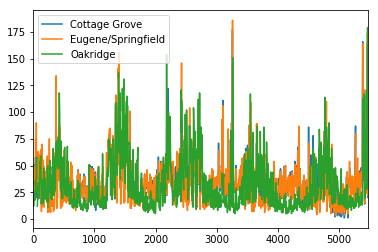

In [12]:
# We can also plot AQI over time (the default index)
by_area['AQI'].plot(); plt.legend();

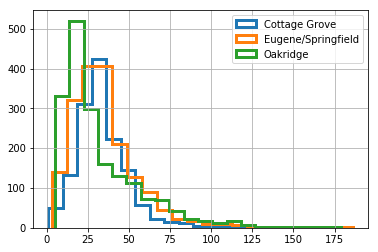

In [13]:
# Or show a histogram for each region
by_area['AQI'].hist(bins=20,histtype='step',stacked=True,linewidth=3)
plt.legend(['Cottage Grove','Eugene/Springfield','Oakridge']);

## Adding columns by merging dataframes
We've been treating the different regions as separate data frames. Let's combine them into a single data frame, with separate columns for AQI from each area. Merging in pandas is similar to joins in SQL.

In [14]:
# Select the rows for each area. We could use something like this:
#    eug = df[df['Reporting Area'] == 'Eugene/Springfield']
# ...or we can select the groups directly from the grouping object.
eug = by_area.get_group('Eugene/Springfield')
cg  = by_area.get_group('Cottage Grove')
oak = by_area.get_group('Oakridge')

# Merge Eugene/Springfield and Cottage Grove data, then add Oakridge.
# Add suffixes to handle columns with identical names.
aqi=pd.merge(left=eug, right=cg, on='Observation Date', suffixes=['_eug','_cg'])
aqi=pd.merge(left=aqi, right=oak, on='Observation Date', suffixes=['','_oak'])

# Remove all rows with N/A
aqi = aqi.dropna()

aqi.head()

,AQI_eug,AQI Category_eug,Observation Date,Pollutant_eug,AQI_cg,AQI Category_cg,Pollutant_cg,AQI,AQI Category,Pollutant
0,31.0,Good,2012-09-01,Ozone,33.0,Good,Ozone,12.0,Good,Particulate Matter
1,31.0,Good,2012-09-02,Ozone,34.0,Good,Ozone,13.0,Good,Particulate Matter
2,36.0,Good,2012-09-03,Ozone,36.0,Good,Ozone,13.0,Good,Particulate Matter
3,37.0,Good,2012-09-04,Ozone,40.0,Good,Ozone,13.0,Good,Particulate Matter
4,45.0,Good,2012-09-05,Ozone,51.0,Moderate,Ozone,26.0,Good,Particulate Matter


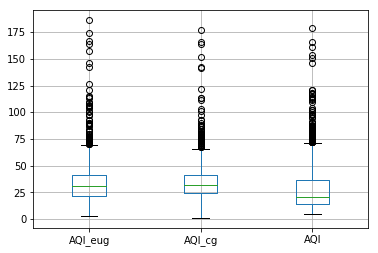

In [15]:
# boxplot() will show a boxplot for all numeric data in the data frame, side by side
aqi.boxplot();

## Contingency Tables
We can use groupby() and size() to create and normalize contingency tables between two categorical variables.
In this case, we'll use the AQI categories for Eugene/Springfield and Cottage Grove, to see if the categories are usually the same or different on the same day.

In [16]:
# To make a contingency table between Eugene/Springfield AQI and Cottage Grove AQI,
# we can group by the AQI category in two regions.
# This will create a subset for each combination. Use .size() to count them.
eug_cg_counts = aqi.groupby(['AQI Category_eug', 'AQI Category_cg']).size()

# Unstack turns the last grouping into columns, giving us a table.
# Fill in unobserved combinations with 0.
eug_cg_counts.unstack(fill_value=0)

AQI Category_cg,Good,Moderate,Somewhat Unhealthy,Unhealthy
AQI Category_eug,,,,
Good,1162,44,0,0
Moderate,82,90,2,0
Somewhat Unhealthy,0,10,4,1
Unhealthy,0,0,2,3


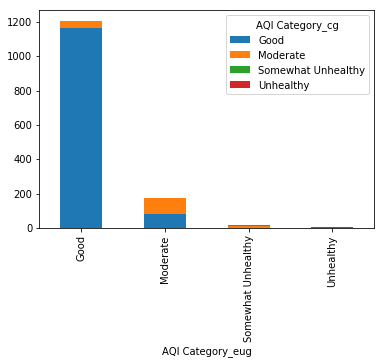

In [26]:
eug_cg_counts.unstack(fill_value=0).plot(kind='bar', stacked=True);

### Normalizing Rows and Columns
Divide by Cottage Grove counts to normalize by columns:

In [34]:
cg_counts = aqi.groupby(['AQI Category_cg']).size()
(eug_cg_counts / cg_counts).unstack(fill_value=0)

AQI Category_cg,Good,Moderate,Somewhat Unhealthy,Unhealthy
AQI Category_eug,,,,
Good,0.934084,0.305556,0.00,0.00
Moderate,0.065916,0.625000,0.25,0.00
Somewhat Unhealthy,0.000000,0.069444,0.50,0.25
Unhealthy,0.000000,0.000000,0.25,0.75


Divide by Eugene/Springfield counts to normalize by rows.

In [35]:
eug_counts = aqi.groupby(['AQI Category_eug']).size()
(eug_cg_counts / eug_counts).unstack(fill_value=0)

AQI Category_cg,Good,Moderate,Somewhat Unhealthy,Unhealthy
AQI Category_eug,,,,
Good,0.963516,0.036484,0.000000,0.000000
Moderate,0.471264,0.517241,0.011494,0.000000
Somewhat Unhealthy,0.000000,0.666667,0.266667,0.066667
Unhealthy,0.000000,0.000000,0.400000,0.600000


Finally, we can plot the normalized contingency table as a stacked bar graph

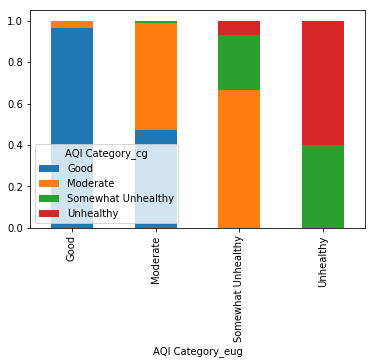

In [40]:
(eug_cg_counts / eug_counts).unstack(fill_value=0).plot(kind='bar', stacked=True);

## Crosstabs: Contingency Tables the Easy Way
Previously, we used groupby, size, and unstack to build and normalize contingency tables. But there's an easier way, built in to pandas: crosstab!

In [29]:
pd.crosstab(aqi['AQI Category_eug'], aqi['AQI Category_cg'], margins=True)

AQI Category_cg,Good,Moderate,Somewhat Unhealthy,Unhealthy,All
AQI Category_eug,,,,,
Good,1162,44,0,0,1206
Moderate,82,90,2,0,174
Somewhat Unhealthy,0,10,4,1,15
Unhealthy,0,0,2,3,5
Very Unhealthy,0,0,0,0,0
All,1244,144,8,4,1400


In [46]:
pd.crosstab(aqi['AQI Category_eug'], aqi['AQI Category_cg'], normalize='columns', margins=True)

AQI Category_cg,Good,Moderate,Somewhat Unhealthy,Unhealthy,All
AQI Category_eug,,,,,
Good,0.934084,0.305556,0.00,0.00,0.861429
Moderate,0.065916,0.625000,0.25,0.00,0.124286
Somewhat Unhealthy,0.000000,0.069444,0.50,0.25,0.010714
Unhealthy,0.000000,0.000000,0.25,0.75,0.003571
Very Unhealthy,0.000000,0.000000,0.00,0.00,0.000000


In [47]:
pd.crosstab(aqi['AQI Category_eug'], aqi['AQI Category_cg'], normalize='index', margins=True)

AQI Category_cg,Good,Moderate,Somewhat Unhealthy,Unhealthy
AQI Category_eug,,,,
Good,0.963516,0.036484,0.000000,0.000000
Moderate,0.471264,0.517241,0.011494,0.000000
Somewhat Unhealthy,0.000000,0.666667,0.266667,0.066667
Unhealthy,0.000000,0.000000,0.400000,0.600000
Very Unhealthy,0.000000,0.000000,0.000000,0.000000
All,0.888571,0.102857,0.005714,0.002857


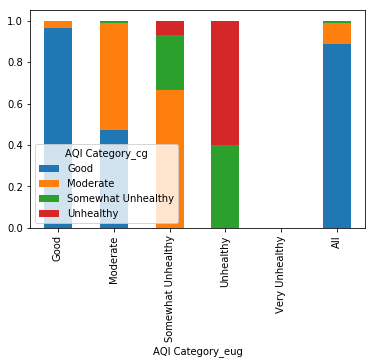

In [48]:
pd.crosstab(aqi['AQI Category_eug'], aqi['AQI Category_cg'], normalize='index', margins=True).plot(kind='bar', stacked=True);

## Scatterplots
Let's plot the AQI in each region as a function of the other to see if there's an association between the two.
We'll use matplotlib for this directly, passing in the columns of numbers we want to plot. An alpha value sets the transparency, so we can see the relative density.

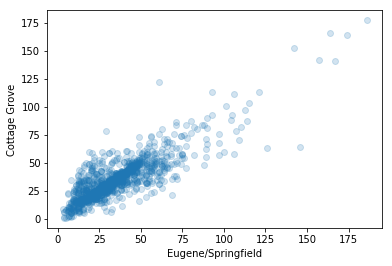

In [49]:
plt.scatter(aqi['AQI_eug'], aqi['AQI_cg'], alpha=0.2)
plt.xlabel('Eugene/Springfield'); plt.ylabel('Cottage Grove');

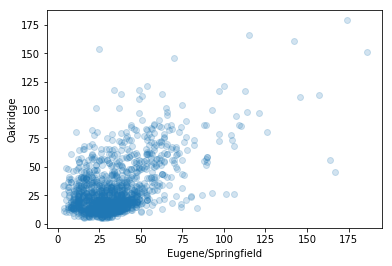

In [50]:
plt.scatter(aqi['AQI_eug'], aqi['AQI'], alpha=0.2)
plt.xlabel('Eugene/Springfield'); plt.ylabel('Oakridge');

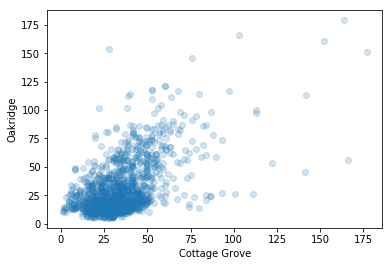

In [51]:
plt.scatter(aqi['AQI_cg'], aqi['AQI'], alpha=0.2)
plt.xlabel('Cottage Grove'); plt.ylabel('Oakridge');